<a href="https://colab.research.google.com/github/hasan-rakibul/AI-cybersec/blob/main/Lab%209/lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven anomaly detection: leveraging LSTM forecasting technique
Forecasting is a technique used to predict future trends based on historical data. In the context of cybersecurity, forecasting can be used to identify patterns and anomalies that may indicate a potential security threat. By analysing patterns in data over time, forecasting algorithms can help detect anomalies in real-time, allowing organisations to proactively respond to potential security incidents before they become major issues.

In this lab, we will use Long Short-Term Memory (LSTM) forecasting algorithm. LSTM is a type of recurrent neural network architecture that is commonly used in deep learning applications. It is designed to handle sequential data and is particularly well-suited for time-series prediction tasks.

One of the main advantages of LSTM is its ability to remember information for extended periods of time, which is important for tasks that require long-term dependencies. This is achieved through the use of gates that regulate the flow of information within the network.

**Reference book:** Chio, C., & Freeman, D. (2018). *Machine learning and security: Protecting systems with data and algorithms* (First edition). O’Reilly Media. (page 102)

**Reference programs:** https://github.com/oreilly-mlsec/book-resources/blob/master/chapter3/lstm-anomaly-detection.ipynb (Modified and bug fixed)

In [50]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense

## Dataset

You can find the datasets at [https://github.com/oreilly-mlsec/book-resources/tree/master/chapter3/datasets/cpu-utilization](https://github.com/oreilly-mlsec/book-resources/tree/master/chapter3/datasets/cpu-utilization)

Download the datasets (`cpu-full-a.csv`, `cpu-full-b.csv`), and keep them in your Google Drive folder (e.g., `Colab Notebooks/AICS/` folder)

Mount your Google Drive from the "Files" menu.

In [51]:
DATA = pd.read_csv(
      '/content/drive/MyDrive/Colab Notebooks/AICS/cpu-full-b.csv'
)
print(DATA.head(5))

              datetime   cpu
0  2017-01-27 18:42:00  1.14
1  2017-01-27 18:43:00  1.10
2  2017-01-27 18:44:00  1.09
3  2017-01-27 18:45:00  1.08
4  2017-01-27 18:46:00  1.08


In [52]:
# if pandas is older
# DATA = pd.read_csv(
#       '/content/drive/MyDrive/Colab Notebooks/AICS/cpu-full-b.csv',
#       parse_dates=[0],
#       infer_datetime_format=True
#   )
# print(DATA.head(5))

The second and third parameters `parse_dates` and `infer_datetime_format` are used to inform pandas how to handle the date/time information in the CSV file.

The `parse_dates` parameter in this case indicates that pandas should parse the first column of the CSV file as dates.

The `infer_datetime_format` parameter is True, which means that pandas will attempt to infer the date/time format from the CSV file.

In [53]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
SEQUENCE_LEN = 100

## Build the LSTM model
### Supplementary reading material
- [Comparison of FFNN and RNN](https://www.researchgate.net/figure/Comparison-of-FFNN-and-RNN_fig1_320944634)
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

In [54]:
def generate_model():
  model = tf.keras.Sequential()

  # First LSTM layer defining the input sequence length
  model.add(
      LSTM(
        input_shape=(SEQUENCE_LEN-1, 1),
        units=32,
        return_sequences=True
      )
    )

  model.add(Dropout(0.2))

  # Second LSTM layer with 128 units
  model.add(
      LSTM(
        units=128,
        return_sequences=True
      )
    )

  model.add(Dropout(0.2))

  # Third LSTM layer with 100 units
  model.add(
      LSTM(
        units=100,
        return_sequences=False  # no more sequence is required for the next layer
      )
    )

  model.add(Dropout(0.2))

  # Densely-connected output layer with Linear activation function
  model.add(
      Dense(
        units=1,
        activation='linear'
      )
    )

  model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)
  )

  return model

The model consists of three LSTM layers with 32, 128, and 100 units respectively, along with a densely-connected output layer with a linear activation function. The input sequence length is defined by the "SEQUENCE_LEN" variable minus one, and the model includes dropout regularization with a rate of 0.2 to prevent overfitting.

The input shape is defined as (SEQUENCE_LEN-1, 1) in the first LSTM layer. The first dimension of the input shape (SEQUENCE_LEN-1) refers to the length of the input sequence, while the second dimension (1) refers to the number of features in each time step of the input sequence.

The model is compiled using the mean squared error loss function and the RMSprop optimizer with a learning rate of 0.001.

## Data preparation

In [55]:
# Z-score normalisation
def normalise(result):
  result_mean = result.mean()
  result_std = result.std()
  result -= result_mean
  result /= result_std
  return result

The function normalises the data by subtracting the mean and dividing by the standard deviation. This is a common technique used to scale and center data around zero, which can help improve the performance of machine learning models.

In [56]:
def prepare_data(data, train_start, train_end, test_start, test_end):
  print("\nLength of Data", len(data))

  # training data
  result = []
  for index in range(train_start, train_end-SEQUENCE_LEN):
    result.append(data[index: index + SEQUENCE_LEN])
  result = np.array(result)
  result = normalise(result)

  print("\nTraining data shape: ", result.shape)
  print("Training data:\n", result)

  np.random.shuffle(result)

  X_train = result[:, :-1]
  y_train = result[:, -1]

  # test data
  result = []
  for index in range(test_start, test_end-SEQUENCE_LEN):
    result.append(data[index: index + SEQUENCE_LEN])
  result = np.array(result)
  result = normalise(result)

  print("\nTest data shape: ", result.shape)
  print("\nTest data:\n", result)

  X_test = result[:, :-1]
  y_test = result[:, -1]

  print("\nShape X_train: ", np.shape(X_train))
  print("Shape X_test: ", np.shape(X_test))

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  print("\nRehaped X_train: ", np.shape(X_train))
  print("Reshaped X_test: ", np.shape(X_test))

  return X_train, y_train, X_test, y_test

The function first prints the length of the input data. It creates two sets of data: one for training and one for testing.

For the training data, the function creates a list result of sequences with length SEQUENCE_LEN by iterating over the input data from train_start to train_end. The result list is then converted to a numpy array and normalised using the normalise function. It then shuffles the normalised training data and separates the input features X_train (all columns except the last) from the target values y_train (the last column).

For the test data, the function follows the same procedure as for the training data, but uses the input data from test_start to test_end instead.

Finally, the function reshapes the input features X_train and X_test to have an additional dimension of size 1.

Reshaping is necessary here because the input data X_train and X_test need to be formatted to fit the input shape of the LSTM layers in the model. Specifically, the LSTM layers in the model expect input data in a 3D format of shape (batch_size, sequence_length, input_dim), where:

- batch_size is the number of samples in each batch of data
- sequence_length is the length of each input sequence
- input_dim is the number of features in the input data

## Running the LSTM model with necessary plotting

In [57]:
def run(model=None, data=None, epochs=3, batch_size=50):
  global_start_time = time.time()

  data = data['cpu'].to_numpy()

  # train on first 700 samples and test on next 300 samples
  X_train, y_train, X_test, y_test = prepare_data(
      data=data,
      train_start=0,
      train_end=400,
      test_start=400,
      test_end=660
  )

  if model is None:
    model = generate_model()

  try:
    print("\nTraining...")
    model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.05
    )
    print("\nPredicting...")
    predicted = model.predict(X_test)

    print("\nShape of raw predicted data:", predicted.shape)
    predicted = np.reshape(predicted, (predicted.size,))
    print("Shape of reshaped predicted data:", predicted.shape)

  except KeyboardInterrupt:
    print("prediction exception")
    print('Training duration:{}'.format(time.time()-global_start_time))
    return model, y_test, 0

  try:
    print("\n")
    plt.figure(figsize=(10, 8))
    plt.plot(y_test, 'b', label='Observed')
    plt.plot(predicted, 'g', label='Predicted')
    plt.plot(((y_test-predicted)**2), 'r', label="Squared error")
    plt.legend()
    plt.show()
  except Exception as e:
    print("plotting exception")
    print(str(e))

  print('\nTraining duration: {}'.format(time.time()-global_start_time))

  return model, y_test, predicted

By setting train_start=0 and train_end=400, the first 400 data points are used for training. Similarly, by setting test_start=400 and test_end=660, the next 260 data points are used for testing. Therefore, the model is trained on the first 400 time steps of the dataset and tested on the subsequent 260 time steps. This split ensures that the model is evaluated on unseen data and not overfitting to the training dataset.

The purpose of predicted = np.reshape(predicted, (predicted.size,)) is to convert the predicted values from a two-dimensional numpy array of shape (n,1) to a one-dimensional numpy array of shape (n,), where n is the number of predicted values.

In other words, the np.reshape() function is used to "flatten" the predicted values array, which makes it easier to perform calculations on the predicted values or to plot them against the actual values.

The first plot command plots the actual values of the test dataset as a blue line with the label "Observed".

The second plot command plots the predicted values of the test dataset as a green line with the label "Predicted".

The third plot command plots the squared error between the predicted and actual values as a red line. ((y_test-predicted)**2) is used to calculate the squared error between the predicted and actual values.


Length of Data 660

Training data shape:  (300, 100)
Training data:
 [[-0.08360845 -0.17863064 -0.20238619 ...  2.22067983  2.43447977
   2.60076861]
 [-0.17863064 -0.20238619 -0.22614174 ...  2.43447977  2.60076861
   1.79307994]
 [-0.20238619 -0.22614174 -0.22614174 ...  2.60076861  1.79307994
   1.31796896]
 ...
 [ 0.55779138  1.17543566  0.72408023 ...  2.38696867  1.88810214
   2.19692428]
 [ 1.17543566  0.72408023  0.41525809 ...  1.88810214  2.19692428
   3.21841289]
 [ 0.72408023  0.41525809  0.22521369 ...  2.19692428  3.21841289
   3.26592399]]

Test data shape:  (160, 100)

Test data:
 [[ 1.65059432  1.76888841  1.11827094 ... -0.85329712 -0.83358144
  -0.675856  ]
 [ 1.76888841  1.11827094  0.80282005 ... -0.83358144 -0.675856
  -0.675856  ]
 [ 1.11827094  0.80282005  1.39429047 ... -0.675856   -0.675856
  -0.65614032]
 ...
 [ 0.94082982  0.78310437  0.50708484 ...  2.24206474  2.34064315
   1.70974136]
 [ 0.78310437  0.50708484  0.36907508 ...  2.34064315  1.70974136
   1

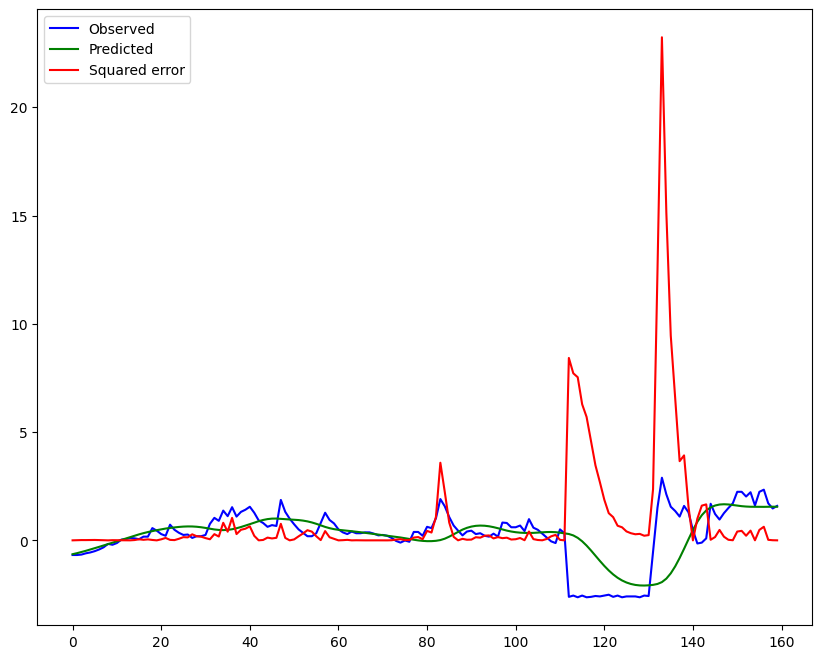


Training duration: 18.78383445739746


In [58]:
model, y_test, predicted = run(data=DATA)

## Practice task
1. Change the `train_start`, `train_end`, `test_start`, and `test_end` parameters in the run function and observe how the generated graph changes in terms of anomaly detection. Try to increase the training data and decrease the test data or vice versa. Comment on how the changes affect the model's ability to detect anomalies.

2. Load the `cpu-full-a.csv` dataset and analyse the dataset to detect anomalies. Experiment with different hyperparameters to achieve better results. Finally, visualise the predictions and the actual data to understand how the model is performing.